# DenseNet201




Kütüphane yüklerken Tensorflow Addons hatası veriyorsa burayı çalıştır. Hata vermiyorsa çalıştırmaya gerek yok.

In [ ]:
!pip install tensorflow_addons

Veri setini kullanmak için öncelikle Dosyalar kısmından ziplenmiş veri setini yükle ardından bu hücredeki kodu çalıştır.

In [ ]:
 !unzip Alzheimer_s\ Dataset.zip

**Kütüphane Yüklemeleri**

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201 # DenseNet201
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

**Veri setinin train, validation, test kümelerine ayrılması.**

In [130]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [131]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [132]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [133]:
test_dataset = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


# Model Oluşturma

In [134]:
base_model = DenseNet201(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

74850304/74836368 [==============================] - 1s 0us/step


In [135]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [136]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [137]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [138]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [139]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [141]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [142]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20
129/129 [==============================] - 99s 627ms/step - loss: 1.0897 - accuracy: 0.7435 - precision: 0.4724 - recall: 0.2216 - auc: 0.7675 - f1_score: 0.2910 - val_loss: 1.0311 - val_accuracy: 0.7852 - val_precision: 0.6017 - val_recall: 0.4164 - val_auc: 0.8013 - val_f1_score: 0.4898 - lr: 0.0100
Epoch 2/20
129/129 [==============================] - 73s 566ms/step - loss: 1.0428 - accuracy: 0.7592 - precision: 0.5461 - recall: 0.2184 - auc: 0.7869 - f1_score: 0.3034 - val_loss: 1.0245 - val_accuracy: 0.7759 - val_precision: 0.5889 - val_recall: 0.3431 - val_auc: 0.8014 - val_f1_score: 0.4308 - lr: 0.0063
Epoch 3/20
129/129 [==============================] - 73s 563ms/step - loss: 1.0081 - accuracy: 0.7758 - precision: 0.6495 - recall: 0.2243 - auc: 0.8016 - f1_score: 0.3293 - val_loss: 0.9785 - val_accuracy: 0.7854 - val_precision: 0.7114 - val_recall: 0.2385 - val_auc: 0.8172 - val_f1_score: 0.3513 - lr: 0.0040
Epoch 4/20
129/129 [==============================] - 73s 

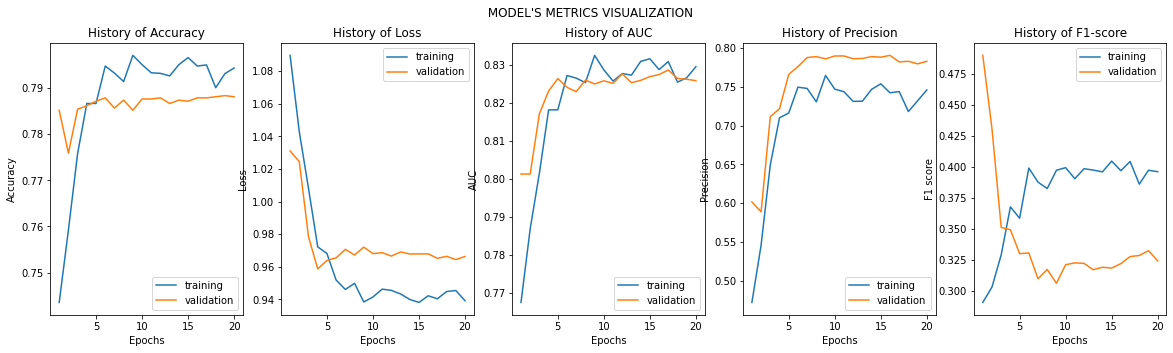

In [143]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [144]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [145]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7922204732894897
Precision =  0.699999988079071
Recall =  0.2955434024333954
AUC =  0.8277338147163391
F1_score =  0.41302114725112915


In [146]:
root_dir = "./"
work_dir = root_dir + "dataset/"
model_dir = work_dir + "densenet201"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['densenet201']